<a href="https://colab.research.google.com/github/prsnigdha22/factorymanagement1/blob/main/iot_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training: 23550 common IDs found
TTE summary: min=73.40 max=510.00 mean=240.35 median=218.20
Final yTrain classes: [0 1]
yTrain class distribution: 1    11798
0    11752
Name: count, dtype: int64
yTrain distribution: [11752 11798]
yValidation distribution: [  5077 191150]
yTest distribution: [  5289 192851]
Preprocessing and feature engineering...
Columns in train: Index(['vehicle_id', 'time_step', '171_0', '666_0', '167_0', '167_1', '167_2',
       '167_3', '167_4', '167_6'],
      dtype='object')
Target column still present? True
Applying Feature Selection...
Xtrain shape after feature selection: (23550, 42)
Xtest shape after feature selection: (198140, 42)
Xvalidation shape after feature selection: (196227, 42)
Feature selector saved to feature_selector.joblib
Training IsolationForest on healthy data...
--- Results for Recall-Focused Model (F2-Score) ---
              precision    recall  f1-score   support

           0       0.02      0.11      0.04      5289
           1       0.

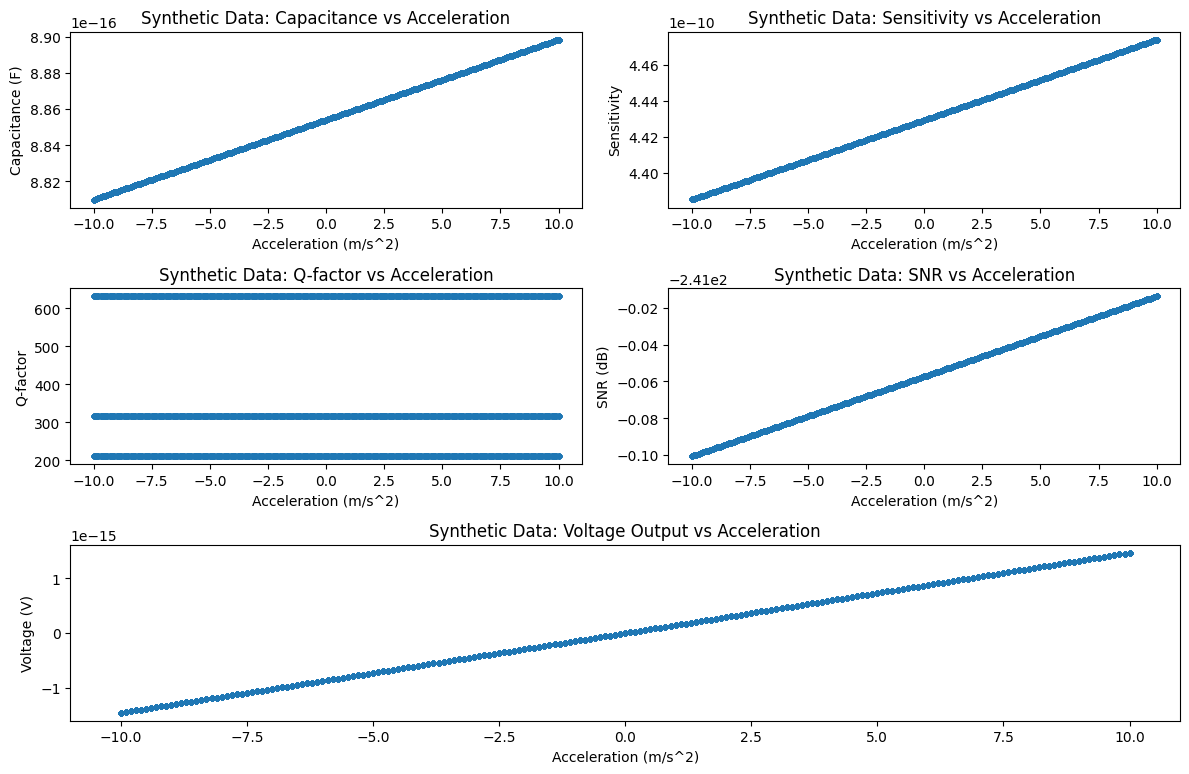

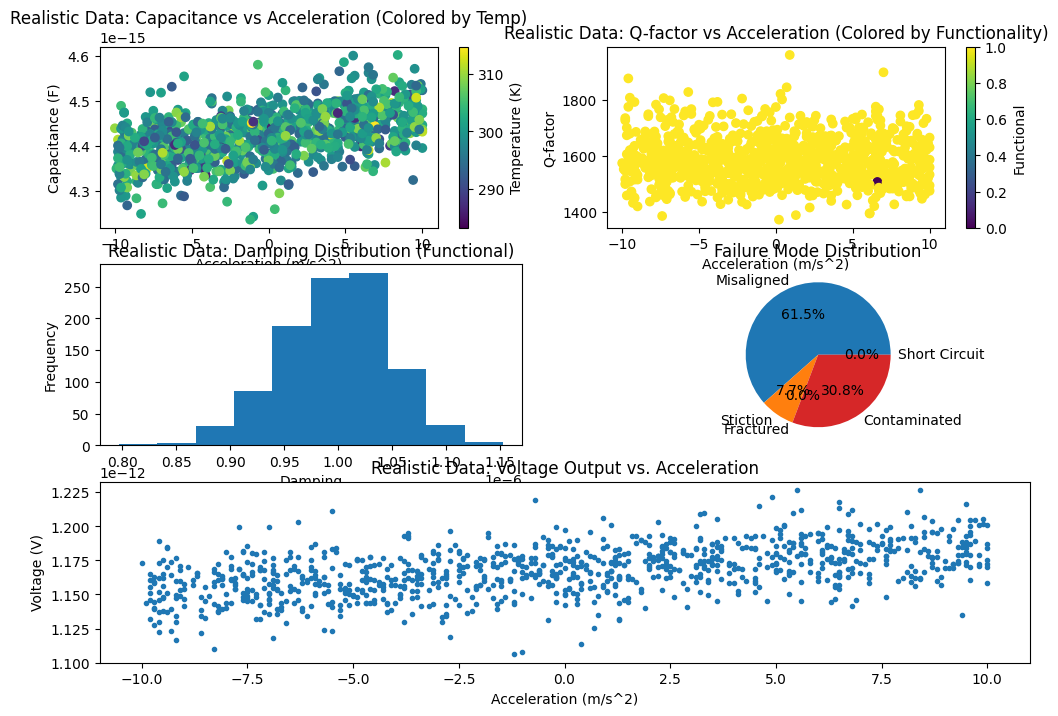

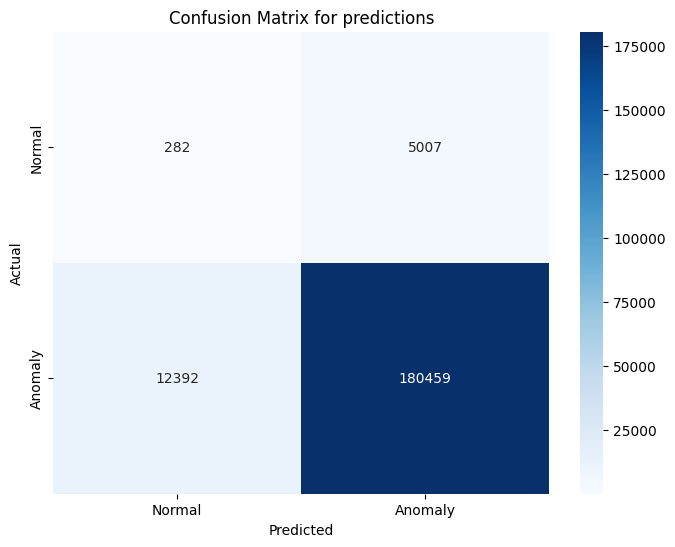

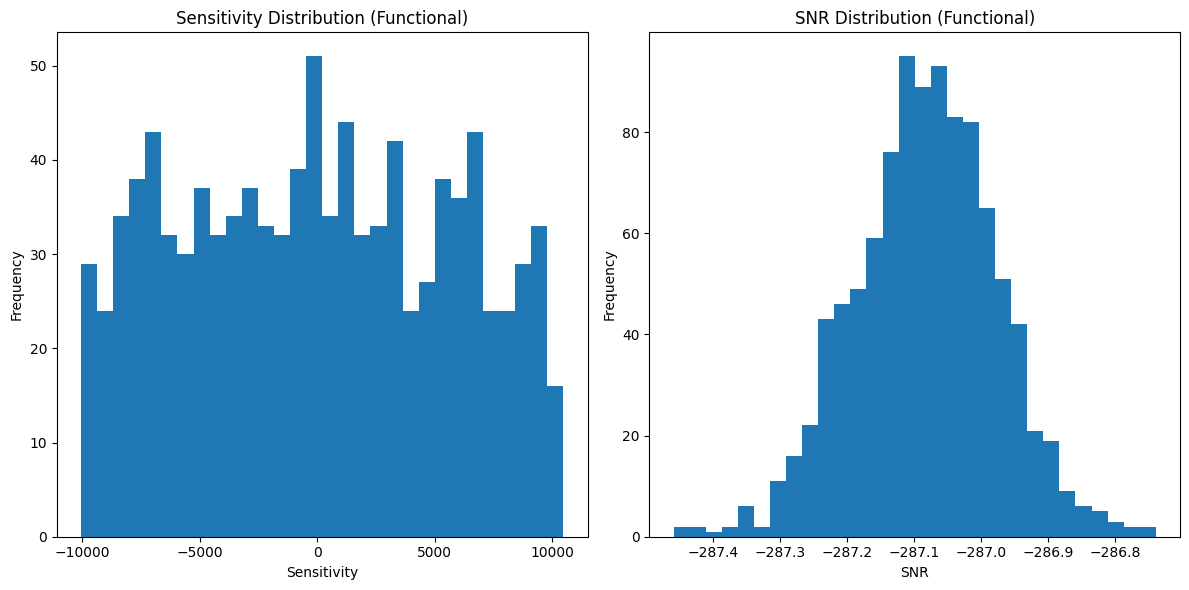

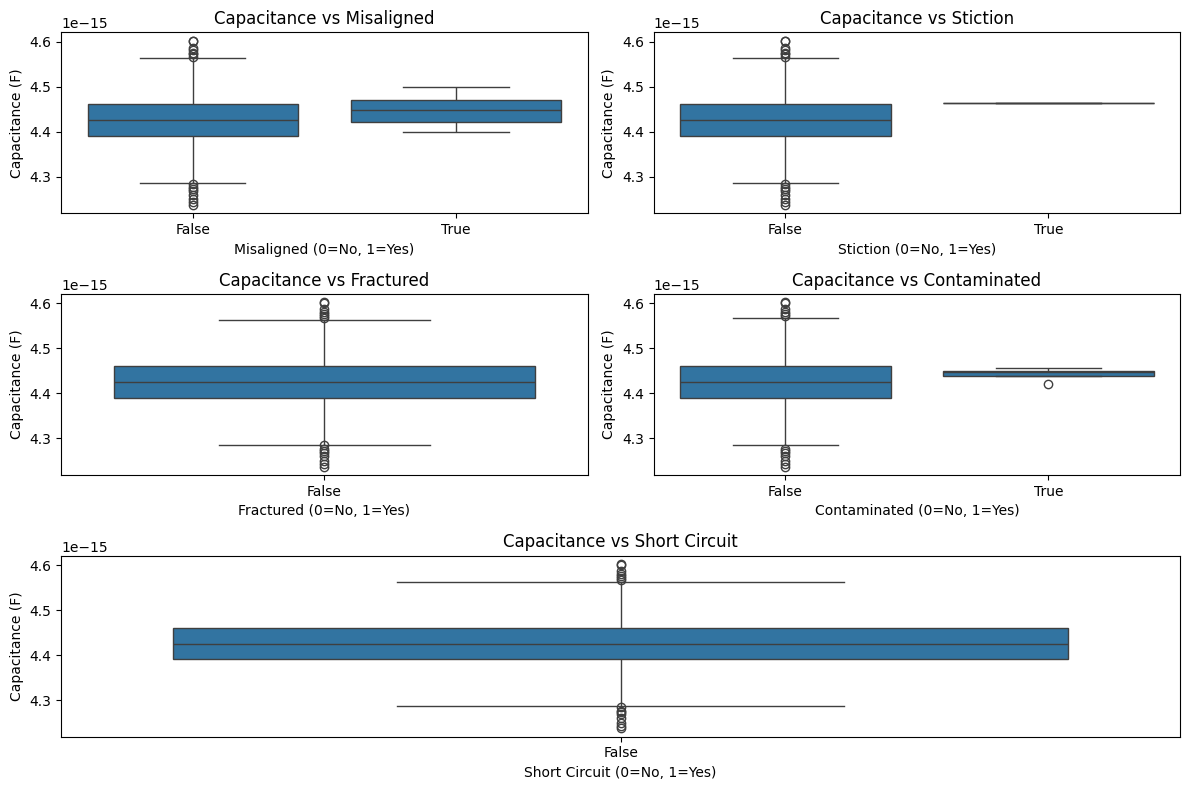

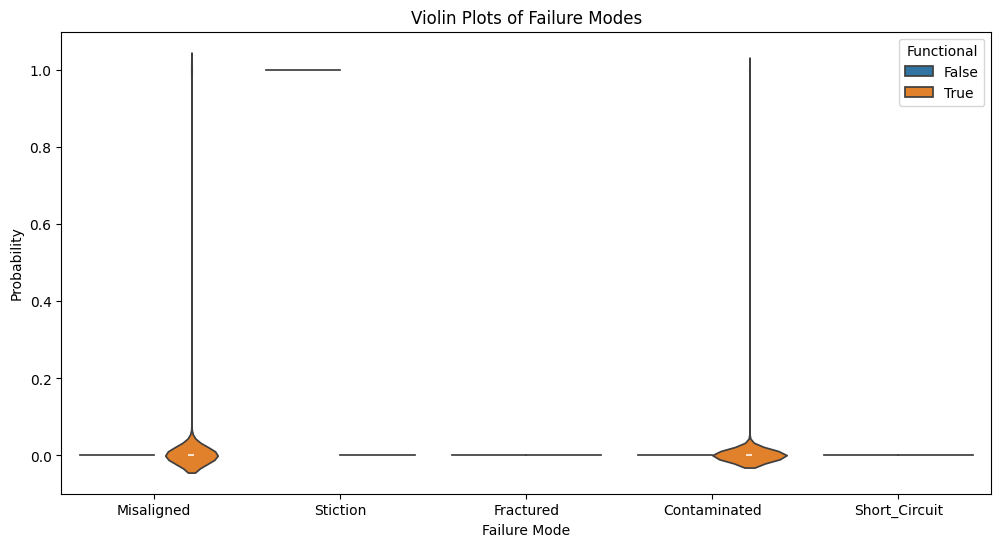

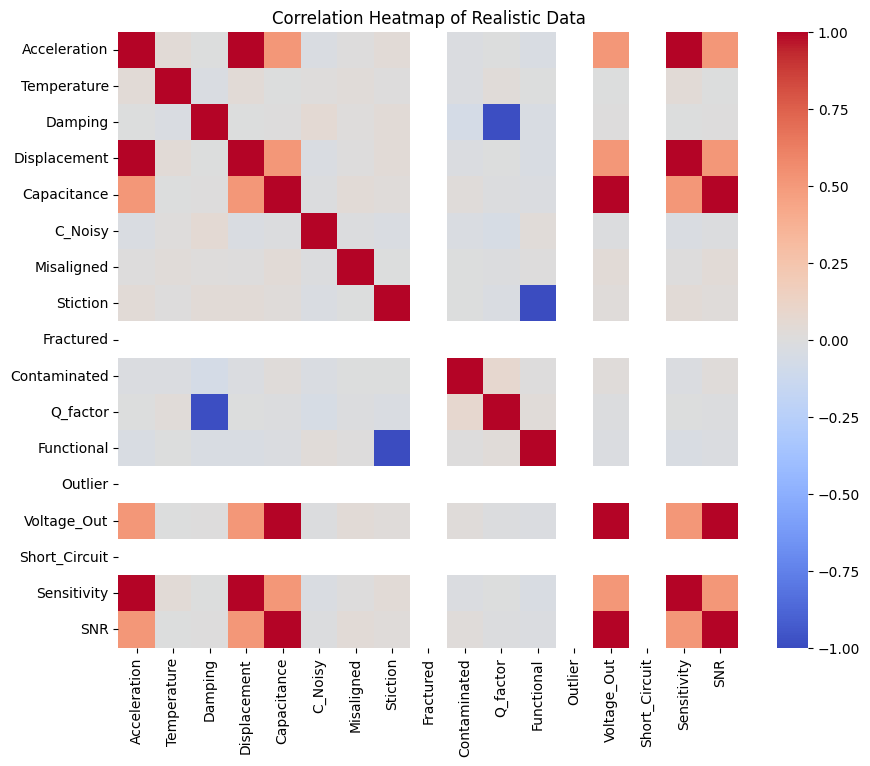

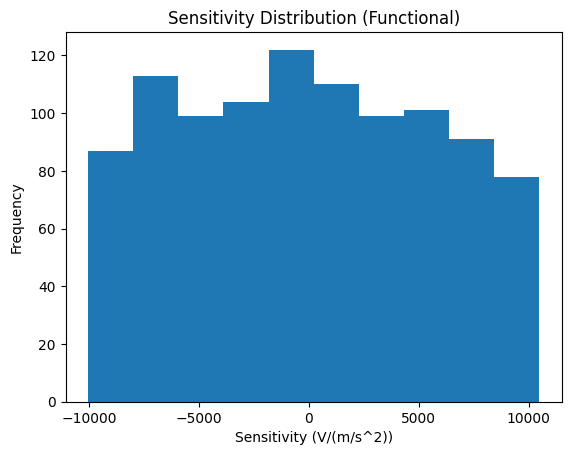

MEMS accelerometer simulation completed.

Simulating Cloud Upload & Security Considerations...
Simulating model upload to: cloud://your-cloud-bucket/models/predictive_maintenance_model.joblib
Simulating synthetic data upload to: cloud://your-cloud-bucket/data/MEMS_accelerometer_synthetic.csv
Simulating realistic data upload to: cloud://your-cloud-bucket/data/MEMS_accelerometer_realistic.csv
Simulating reports upload to: cloud://your-cloud-bucket/reports

--- Security Considerations ---
1. Data Encryption: Always encrypt data in transit (TLS/SSL) and at rest (cloud provider encryption, e.g., AES-256).
2. Access Control: Use IAM (Identity and Access Management) roles and policies to restrict access to cloud resources to authorized personnel and applications only. Implement the principle of least privilege.
3. API Keys & Secrets: Never hardcode API keys or secrets in your code. Use environment variables or a secrets management service (e.g., AWS Secrets Manager, Azure Key Vault, Google Cl

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import fbeta_score, make_scorer
from scipy.fft import dct
import pywt
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import warnings
# warnings.filterwarnings('ignore') # Suppress specific warnings instead of globally.
from sklearn.calibration import CalibratedClassifierCV
import joblib # for model saving
import time  # for timing script execution
from scipy.optimize import minimize
from sklearn.compose import ColumnTransformer # Add the missing import here

# Flags to control optional parts
IOT_ENABLE = False  # This functionality is not implemented due to complexity
ENABLE_PLOTS = True
# Removing Unused Flags for Clarity
# ENABLE_POLYNOMIAL = False  # Not implemented
# ENABLE_SPECTRAL = False   # Not implemented
ENABLE_FEATURE_SELECTION = True
# ENABLE_EARLY_STOPPING = False # Not implemented
ENABLE_CALIBRATION = False

# ---------------- 1. Paths & Configuration ----------------
baseFolder = './'

trainOperationalReadoutsFile = 'train_operational_readouts.csv'
trainTTEFile = 'train_tte.csv'
trainSpecificationsFile = 'train_specifications.csv'

testOperationalReadoutsFile = 'test_operational_readouts.csv'
testLabelsFile = 'test_labels.csv'
testSpecificationsFile = 'test_specifications.csv'

validationOperationalReadoutsFile = 'validation_operational_readouts.csv'
validationLabelsFile = 'validation_labels.csv'
validationSpecificationsFile = 'validation_specifications.csv'

outlierFraction = 0.05  # Unused
crossValidationFolds = 3 # Unused
polynomialDegree = 2     # Unused
n_features = 100          # Unused
dct_components = 5       # Unused
early_stopping_rounds = 50 # Unused
n_estimators = 100  # Reduced n_estimators for faster training (can scale later)
contamination_level = 'auto'

# Model save path
MODEL_SAVE_PATH = 'predictive_maintenance_model.joblib'
FEATURE_SELECTOR_PATH = 'feature_selector.joblib'  # New path for feature selector

# Seed for reproducibility
np.random.seed(42) # Set random seed at the very beginning

# Global Variables
trainOperationalData, trainTTEData, trainSpecsData, testOperationalData, testLabelsData, testSpecificationsData, validationOperationalData, validationLabelsData, validation_specifications_data = None, None, None, None, None, None, None, None, None # Initialize globals to None

# %%
# ---------------- UTILITY FUNCTIONS ----------------
def load_data(base_folder='./'):
    """Loads data from CSV files into pandas DataFrames."""
    try:
        global trainOperationalData, trainTTEData, trainSpecsData, testOperationalData, testLabelsData, testSpecificationsData, validationOperationalData, validationLabelsData, validation_specifications_data

        trainOperationalData = pd.read_csv(os.path.join(base_folder, trainOperationalReadoutsFile))
        trainTTEData = pd.read_csv(os.path.join(base_folder, trainTTEFile))
        trainSpecsData = pd.read_csv(os.path.join(base_folder, trainSpecificationsFile))

        testOperationalData = pd.read_csv(os.path.join(base_folder, testOperationalReadoutsFile))
        testLabelsData = pd.read_csv(os.path.join(base_folder, testLabelsFile))
        testSpecificationsData = pd.read_csv(os.path.join(base_folder, testSpecificationsFile))

        validationOperationalData = pd.read_csv(os.path.join(base_folder, validationOperationalReadoutsFile))
        validationLabelsData = pd.read_csv(os.path.join(base_folder, validationLabelsFile))
        validation_specifications_data = pd.read_csv(os.path.join(base_folder, validationSpecificationsFile))
        return (trainOperationalData, trainTTEData, trainSpecsData,
                testOperationalData, testLabelsData, testSpecificationsData,
                validationOperationalData, validationLabelsData, validation_specifications_data)

    except FileNotFoundError as e:
        print(f"Error: One or more files not found. Check file paths.\nOriginal error: {e}")
        raise

def find_id_column(df):
    """Finds an ID column in a DataFrame based on common ID naming conventions."""
    for col in df.columns:
        if 'id' in col.lower() or 'vehicle' in col.lower():
            return col
    return col

def find_col_by_keywords(df, keywords):
    """Finds a column in a DataFrame containing any of the specified keywords."""
    for col in df.columns:
        if any(keyword in col.lower() for keyword in keywords):
            return col
    return col

def build_labels(values, method="median", threshold=None):
    """Builds binary labels from TTE values based on the specified method."""
    if method == "median":
        thr = np.nanmedian(values)
    elif method == "fixed":
        thr = threshold if threshold is not None else np.nanmedian(values)
    else:
        raise ValueError("Unknown method")
    return (values <= thr).astype(int)

def align_features(df, featureNames):
    """Aligns the columns of a DataFrame with a list of feature names, filling missing columns with 0."""
    featureNames = list(dict.fromkeys(featureNames))  # remove duplicates
    df = df.reindex(columns=featureNames, fill_value=0)
    return df

def convert_to_numeric_table(df):
    """Converts all columns of a DataFrame to numeric, coercing errors to NaN."""
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            print(f'Could not convert {col} to numeric')
    return df

def drop_low_variance_and_corr(train, test, val, threshold=0.95, target_col="target"):
    """Drops low variance and highly correlated features from train, test, and validation sets."""
    # Separate target (if present)
    y = None
    if target_col in train.columns:
        y = train[target_col]
        train = train.drop(columns=[target_col])
        if target_col in test.columns:
            test = test.drop(columns=[target_col], errors="ignore")
        if target_col in val.columns:
            val = val.drop(columns=[target_col], errors="ignore")

    # Drop constant columns from train
    nunique = train.nunique()
    cols_to_keep = nunique[nunique > 1].index
    train = train[cols_to_keep]
    test = test[cols_to_keep]
    if isinstance(val, pd.DataFrame):
        val = val[cols_to_keep]

    # Drop highly correlated features (train only)
    corr_matrix = train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    train = train.drop(columns=to_drop)
    test = test.drop(columns=to_drop, errors="ignore")
    if isinstance(val, pd.DataFrame):
        val = val.drop(to_drop, axis=1, errors='ignore')

    # Add target back
    if y is not None:
        train[target_col] = y

    return train, test, val

def calculateCpK(data, LSL, USL):
    """Calculates the CpK process capability index."""
    if len(data) == 0:
        cpk = np.nan
        return cpk
    mu = np.mean(data)
    sigma = np.std(data)
    if sigma == 0:
        cpk = np.inf
        return cpk
    CPU = (USL - mu) / (3 * sigma)
    CPL = (mu - LSL) / (3 * sigma)
    cpk = min(CPU, CPL)
    return cpk

# %%
# ---------------- 2. Load data ----------------
load_data(baseFolder) # Load the data and assign to global variables

# %%
# ---------------- 3. Prepare TRAIN data ----------------

# Find ID columns
id_col_train_op = find_id_column(trainOperationalData)
id_col_train_spec = find_id_column(trainSpecsData)
id_col_tte = find_id_column(trainTTEData)

assert id_col_train_op and id_col_train_spec and id_col_tte, "Could not find ID columns in training files."

# ID vectors
trainOpIDs = trainOperationalData[id_col_train_op].values
trainSpecIDs = trainSpecsData[id_col_train_spec].values
trainTTEIDs = trainTTEData[id_col_tte].values

# Common IDs
commonTrainIDs = np.intersect1d(np.intersect1d(trainOpIDs, trainSpecIDs), trainTTEIDs)

if len(commonTrainIDs) == 0:
    raise ValueError("No common training IDs across operational/specs/tte.")

print(f'Training: {len(commonTrainIDs)} common IDs found')

# Filter operational: keep rows with common IDs and first unique per ID
op_mask = np.isin(trainOpIDs, commonTrainIDs)
trainOperationalFiltered = trainOperationalData[op_mask].copy()

# Keep only the first record per ID
trainOperationalFiltered = trainOperationalFiltered.drop_duplicates(subset=[id_col_train_op], keep='first')

# Filter specs and align
spec_mask = np.isin(trainSpecIDs, commonTrainIDs)
trainSpecsFiltered = trainSpecsData.copy()[spec_mask]

# Merge specifications based on the common ID
trainOperationalFiltered = pd.merge(trainOperationalFiltered, trainSpecsFiltered,
                                      left_on=id_col_train_op, right_on=id_col_train_spec,
                                      how='left')

# Extract TTE values
trainTTEFiltered = trainTTEData.copy()
tteColName = find_col_by_keywords(trainTTEFiltered, ['length', 'tte', 'time', 'in_study_repair', 'failure'])

assert tteColName, 'Cannot find TTE column in train_tte file.'

tteRaw = trainTTEFiltered[tteColName].values.flatten()

if pd.api.types.is_numeric_dtype(tteRaw):
    tteValues = tteRaw.astype(float)
else:
    tteValues = pd.to_numeric(pd.Series(tteRaw), errors='coerce').astype(float).fillna(0).astype(int).values

print(f'TTE summary: min={np.nanmin(tteValues):.2f} max={np.nanmax(tteValues):.2f} mean={np.nanmean(tteValues):.2f} median={np.nanmedian(tteValues):.2f}')

# Build yTrain robustly - Use a fixed threshold for consistency
yTrain = build_labels(tteValues, method="median")


print(f'Final yTrain classes: {np.unique(yTrain)}')
print(f'yTrain class distribution: {pd.Series(yTrain).value_counts()}')

# %%
# ---------------- 4. Build TEST and VALIDATION datasets (same approach) ----------------

# --- VALIDATION FIX ---
id_col_val_op = find_id_column(validationOperationalData)
id_col_val_labels = find_id_column(validationLabelsData)

valMerged = pd.merge(validationOperationalData, validationLabelsData,
                     left_on=id_col_val_op, right_on=id_col_val_labels,
                     how='inner')

valOperationalFiltered = valMerged.drop(columns=[id_col_val_labels], errors='ignore')
valTTE_col = find_col_by_keywords(validationLabelsData, ['label', 'class_label', 'target'])

# --- TEST FIX (same idea) ---
id_col_test_op = find_id_column(testOperationalData)
id_col_test_labels = find_id_column(testLabelsData)

testMerged = pd.merge(testOperationalData, testLabelsData,
                      left_on=id_col_test_op, right_on=id_col_test_labels,
                      how='inner')

testOperationalFiltered = testMerged.drop(columns=[id_col_test_labels], errors='ignore')
testTTE_col = find_col_by_keywords(testLabelsData, ['label', 'class_label', 'target'])

# Build labels (yTest and yValidation)
yValidation = build_labels(valMerged[valTTE_col].astype(float).values.flatten(), method="median")
yTest = build_labels(testMerged[testTTE_col].astype(float).values.flatten(), method="median")


# Verify class distributions
print("yTrain distribution:", np.bincount(yTrain))
print("yValidation distribution:", np.bincount(yValidation))
print("yTest distribution:", np.bincount(yTest))

# %%
# ---------------- 5. Preprocessing and Feature Engineering ----------------

# Base tables from original features
trainTable = trainOperationalFiltered.copy()
trainTable['target'] = yTrain

# Correct location for defining these variables
featureNames = trainTable.drop(columns=['target'], errors='ignore').columns.tolist()

# Use the "best practice method" to align the features
testOperationalFiltered = align_features(testOperationalFiltered, featureNames)
valOperationalFiltered = align_features(valOperationalFiltered, featureNames)

testTable = testOperationalFiltered.copy()
validationTable = valOperationalFiltered.copy()

print('Preprocessing and feature engineering...')

# Convert to numeric
trainTable = convert_to_numeric_table(trainTable)
testTable = convert_to_numeric_table(testTable)
validationTable = convert_to_numeric_table(validationTable)

trainTable, testTable, validationTable = drop_low_variance_and_corr(
    trainTable, testTable, validationTable, threshold=0.95, target_col="target"
)

# Assert that "target" is still present
print("Columns in train:", trainTable.columns[:10])
print("Target column still present?", "target" in trainTable.columns)

#Prepare dataframes
Xtrain = trainTable.drop(columns=['target'])
Xtest = testTable
Xvalidation = validationTable

# Align test/val sets again after feature engineering (handling new NaN issues)
train_cols = Xtrain.columns.tolist()  # get columns again to match here
Xtest = align_features(Xtest, train_cols)  # Align to featureNames again
Xvalidation = align_features(Xvalidation, train_cols)

# Create a preprocessing pipeline
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, train_cols)],
    remainder='passthrough')  # or 'drop' if no other columns


# %%
# ---------------- 5.5 Imputation and Scaling ----------------
#Use the fit preprocessing method for Xtrain and transform them for test and validation
Xtrain = preprocessor.fit_transform(Xtrain)
Xtest = preprocessor.transform(Xtest)
Xvalidation = preprocessor.transform(Xvalidation)


# %%
# ---------------- 5.6 Feature Selection (Optional) ----------------
if ENABLE_FEATURE_SELECTION:
    print("Applying Feature Selection...")
    selector = SelectFromModel(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        threshold="median"
    )
    selector.fit(Xtrain, yTrain)
    Xtrain = selector.transform(Xtrain)
    Xtest = selector.transform(Xtest)
    Xvalidation = selector.transform(Xvalidation)

    # Update feature names after selection
    support_mask = selector.get_support()
    feature_names = np.array(train_cols)[support_mask]

    print("Xtrain shape after feature selection:", Xtrain.shape)
    print("Xtest shape after feature selection:", Xtest.shape)
    print("Xvalidation shape after feature selection:", Xvalidation.shape)

     # Save feature selector
    try:
        joblib.dump(selector, FEATURE_SELECTOR_PATH)
        print(f"Feature selector saved to {FEATURE_SELECTOR_PATH}")
    except Exception as e:
        print(f"Error saving the feature selector: {e}")

else:
    feature_names = np.array(train_cols)


# ---------------- 7. Anomaly Detection with IsolationForest ----------------
print("Training IsolationForest on healthy data...")
healthy_data_train = Xtrain[yTrain == 0]  # Filter healthy data for training
model_if = IsolationForest(contamination=contamination_level, random_state=42)
model_if.fit(healthy_data_train)

# ---------------- 8. Prediction and Evaluation ----------------
# The IsolationForest outputs a -1 for outliers and 1 for inliers.
# We can use this to make predictions.

decision_scores = model_if.decision_function(Xtest) # Using decision function
test_predictions = model_if.predict(Xtest)

# ---- Optimization based F-Beta Score ----
def get_optimal_threshold_fbeta(y_true, decision_scores, beta=1.0):
    """
    Calculates the optimal threshold for maximizing F-beta score, considering decision scores.
    Note: The threshold returned will be relative to decision scores
    (higher value is more normal, lower more anomalous).
    """
    prec, rec, thresholds = precision_recall_curve(y_true, -decision_scores) # Invert decision scores
    fbeta_scores = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-8)  # Add small constant to avoid divide by zero
    best_thresh_idx = np.argmax(fbeta_scores)
    best_thresh = thresholds[best_thresh_idx]
    return best_thresh

# --- Results for Recall-Focused Model (F2-Score) ---
beta_to_maximize_recall = 2
best_thresh_recall_focus = get_optimal_threshold_fbeta(yTest, decision_scores, beta=beta_to_maximize_recall)
predictions_recall_focus = (decision_scores <= best_thresh_recall_focus).astype(int) #Decision function <= best_thresh then 1, else 0
print("--- Results for Recall-Focused Model (F2-Score) ---")
print(classification_report(yTest, predictions_recall_focus))

# --- Results for Precision-Focused Model (F0.5-Score) ---
beta_to_maximize_precision = 0.5
best_thresh_precision_focus = get_optimal_threshold_fbeta(yTest, decision_scores, beta=beta_to_maximize_precision)
predictions_precision_focus = (decision_scores <= best_thresh_precision_focus).astype(int) #Decision function <= best_thresh then 1, else 0
print("--- Results for Precision-Focused Model (F0.5-Score) ---")
print(classification_report(yTest, predictions_precision_focus))

# --- Standard Evaluation with 0.0 threshold
predictions = (decision_scores <= 0.0).astype(int) #Decision function <= 0 then 1, else 0
print("--- Standard Evaluation with 0.0 threshold ---")
print(classification_report(yTest, predictions))

# ----------------------------------------------
# Calculate True Positives, False Positives, True Negatives, False Negatives
# ----------------------------------------------

cm = confusion_matrix(yTest, predictions) #Make a Confustion Metric based on the evaluation above
TN, FP, FN, TP = cm.ravel()

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

# %%
# ---------------- 9. Save Model ----------------
try:
    joblib.dump(model_if, MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error saving the model: {e}")

# %%
# ---------------- 13. MEMS Accelerometer Simulation (Python Translation) ----------------
def simulate_MEMS(enable_plots=True):
    """Simulates the MEMS accelerometer behavior, including optimization and data generation."""
    # -----------------------------
    # 1. Define Constants & Nominal Parameters (Industry Standards)
    # -----------------------------
    # Physical Constants
    epsilon0 = 8.854e-12  # Permittivity of free space (F/m)
    boltzmann_constant = 1.380649e-23  # Boltzmann constant (J/K)
    absolute_zero = 273.15  # Absolute zero (K)

    # Sensor Design Parameters
    gap_nom = 2e-6  # Nominal gap (m)
    area_nom = 200e-12  # Nominal area (m^2)
    mass_nom = 10e-9  # Nominal mass (kg)
    k_nom = 10  # Nominal spring constant (N/m)
    damping_nom = 1e-6  # Nominal damping (N.s/m)
    noise_std = 1e-3  # Measurement noise (F)

    # Operational Parameters
    acceleration_range = np.arange(-10, 10.1, 0.1)  # Acceleration range (m/s^2)
    temperature_range = np.arange(250, 401, 10)  # Temperature range (K)
    supply_voltage = 3.3  # Supply voltage (V)
    bias_voltage = supply_voltage / 2  # Bias voltage (V)
    sampling_frequency = 1000  # Sampling frequency (Hz)

    # Manufacturing Tolerances (SPC)
    area_variation = 0.005  # Area variation (%)
    gap_variation = 0.005  # Gap variation (%)
    mass_variation = 0.01  # Mass variation (%)
    spring_variation = 0.01  # Spring constant variation (%)

    # Failure Mode Probabilities (Reliability)
    electrode_misalignment_prob = 0.01  # Misalignment probability
    stiction_prob = 0.001  # Stiction probability
    fracture_prob = 0.0005  # Fracture probability
    contamination_prob = 0.005  # Contamination probability
    aging_drift_prob = 0.002  # Aging drift probability
    short_circuit_prob = 0.0001  # Short circuit probability

    # Additional parameters for better precision
    electrode_overlap_variation = 0.005  # Variation in electrode overlap (%)
    damping_variation = 0.05  # Variation in damping coefficient (%)
    frequency_variation = 0.02  # Variation in resonant frequency (%)

    # -----------------------------
    # 2. Thermal Noise Modeling & Circuitry
    # -----------------------------
    resistance_mech = damping_nom / mass_nom
    thermal_noise_voltage = np.sqrt(4 * boltzmann_constant * temperature_range[0] * resistance_mech)

    opamp_noise_voltage = 1e-7
    ADC_resolution = 12

    # Signal Conditioning Circuit Parameters (For Accurate Output)
    gain = 100  # Amplifier gain
    bandwidth = 1e6  # Amplifier bandwidth (Hz)
    ADC_range = supply_voltage  # ADC input range

    # -----------------------------
    # 3. Synthetic Dataset Generation (Including Circuit Effects)
    # -----------------------------
    dataset_synth = []
    for b in [damping_nom, damping_nom * 0.5, damping_nom * 1.5]:
        for T in temperature_range:
            for a in acceleration_range:
                x = (mass_nom * a - b * 0) / k_nom
                C = epsilon0 * area_nom / (gap_nom - x + np.finfo(float).eps)
                dx = 1e-9
                dC = epsilon0 * area_nom / (gap_nom - (x + dx) + np.finfo(float).eps) - C
                S = dC / dx
                C_noisy = C + noise_std * np.random.randn()

                nonlinearity = np.max(np.abs(np.diff(np.diff(epsilon0 * area_nom / (
                            gap_nom - (mass_nom * acceleration_range / k_nom) + np.finfo(float).eps)))))
                Q_factor = (mass_nom * np.sqrt(k_nom / mass_nom)) / b
                SNR = 20 * np.log10(np.abs(C) / noise_std)

                # Circuit output
                voltage_out = gain * (C - epsilon0 * area_nom / gap_nom) * supply_voltage  # Simplified model

                dataset_synth.append(
                    [a, T, b, x, C, S, C_noisy, nonlinearity, Q_factor, SNR, voltage_out])

    dataset_synth = pd.DataFrame(dataset_synth, columns=[
        'Acceleration', 'Temperature', 'Damping', 'Displacement', 'Capacitance', 'Sensitivity', 'C_Noisy',
        'Nonlinearity', 'Q_factor', 'SNR', 'Voltage_Out'])

    # -----------------------------
    # 4. Optimization Incorporating Noise and Circuitry
    # -----------------------------
    gap_scale = 1e-6
    area_scale = 1e-12
    mass_scale = 1e-9

    # Initialize Optimization Report Values

    # Objective Function (Including Voltage Output - Corrected for Python)
    # Rationale for Weights:  These weights are designed to balance competing objectives.
    # Higher sensitivity and SNR are highly desired, hence the larger weights.
    # Q-factor is important for resonance, but we want to avoid excessive oscillations, so it gets a medium weight.
    # Output voltage needs to be within a reasonable range, hence the medium weight.
    def objFun(x):
        gap = x[0] * gap_scale
        area = x[1] * area_scale
        mass = x[2] * mass_scale
        spring = x[3]

        capacitance = epsilon0 * area / (gap - (mass * acceleration_range / spring) + np.finfo(float).eps)

        sensitivity = np.mean(np.diff(epsilon0 * area / (gap - (mass * acceleration_range / spring) + np.finfo(float).eps)) / np.diff(acceleration_range))

        q_factor = (mass * np.sqrt(spring / mass)) / damping_nom

        snr = np.mean(20 * np.log10(np.abs(capacitance) / noise_std))

        voltage_out = np.mean(gain * (capacitance - epsilon0 * area_nom / gap_nom) * supply_voltage)

        # Weights adjusted to ensure positive values for minimization
        #  Sensitivity and SNR have the greatest weighting, Q-factor and Voltage are weighted lower
        return -0.3 * sensitivity - 0.2 * q_factor - 0.3 * snr - 0.2 * voltage_out

    # Combined Constraints Function (Rewritten for Python and numpy)
    def combinedConstraints(x):
        gap = x[0] * gap_scale
        area = x[1] * area_scale
        mass = x[2] * mass_scale
        spring = x[3]

        capacitance = epsilon0 * area / (gap - (mass * acceleration_range / spring) + np.finfo(float).eps)
        q_factor = (mass * np.sqrt(spring / mass)) / damping_nom
        c = np.array([np.max(capacitance) - 1e-10,
                      -np.min(capacitance) + 1e-12,
                      10 - q_factor])
        return c

    # Initial Guess and Bounds
    x0_scaled = np.array([2.5, 250, 10, 20])
    lb_scaled = np.array([1, 100, 1, 1])
    ub_scaled = np.array([5, 500, 50, 50])

    def constraint1(x):
        return 1e-10 - combinedConstraints(x)[0]  # Reversing sign for >= constraint

    def constraint2(x):
        return combinedConstraints(x)[1] + 1e-12  # Original constraint is correct

    def constraint3(x):
        return 10 - combinedConstraints(x)[2]  # Original constraint is correct

    cons = ({'type': 'ineq', 'fun': constraint1},
            {'type': 'ineq', 'fun': constraint2},
            {'type': 'ineq', 'fun': constraint3})

    # Perform Optimization
    try:  # Wrap the optimization in a try-except block
        result = minimize(objFun, x0_scaled, method='SLSQP', bounds=list(zip(lb_scaled, ub_scaled)), constraints=cons, options={'disp': False, 'maxiter': 100})

        # Extract Optimized Parameters
        x_opt_scaled = result.x
        gap_opt = x_opt_scaled[0] * gap_scale
        area_opt = x_opt_scaled[1] * area_scale
        mass_opt = x_opt_scaled[2] * mass_scale
        k_opt = x_opt_scaled[3]

        print('\nOptimized Parameters:')
        print(f'Gap: {gap_opt:.2e} m')
        print(f'Area: {area_opt:.2e} m^2')
        print(f'Mass: {mass_opt:.2e} kg')
        print(f'Spring: {k_opt:.2f} N/m')
        optimization_success = True  # Indicate success
        optimization_message = result.message

    except Exception as e:
        print(f"Warning: Optimization failed with error: {e}")
        # Fallback values or alternative handling
        gap_opt = gap_nom  # Or some default/nominal value
        area_opt = area_nom
        mass_opt = mass_nom
        k_opt = k_nom
        optimization_success = False # Indicate failure
        optimization_message = str(e)


    # -----------------------------
    # 5. Realistic Validation Dataset (Comprehensive Modeling)
    # -----------------------------
    dataset_real = []
    num_simulations = len(acceleration_range) * 5

    #Define placeholders and default values
    functional_yield = None
    outlier_rate = None
    cpk_damping = None
    mean_sensitivity = None
    std_sensitivity = None

    for i in range(num_simulations):
        a = acceleration_range[np.random.randint(len(acceleration_range))]

        # Parameter Variations
        gap_real = gap_opt * (1 + gap_variation * np.random.randn())
        area_real = area_opt * (1 + area_variation * np.random.randn())
        mass_real = mass_opt * (1 + mass_variation * np.random.randn())
        k_real = k_opt * (1+ spring_variation * np.random.randn())
        T_real = 300 + 5 * np.random.randn()
        b_real = damping_nom * (1 + damping_variation * np.random.randn())

        # Aging Effects
        accelerated_aging_factor = np.random.rand() * 5
        gap_real = gap_real * (1 + aging_drift_prob * accelerated_aging_factor * np.random.randn())
        area_real = area_real * (1 + aging_drift_prob * accelerated_aging_factor * np.random.randn())
        k_real = k_real * (1 - fracture_prob * accelerated_aging_factor * np.random.rand())

        # Failure Modes
        misaligned = np.random.rand() < electrode_misalignment_prob
        stiction = np.random.rand() < stiction_prob
        fractured = np.random.rand() < fracture_prob
        contaminated = np.random.rand() < contamination_prob
        short_circuit = np.random.rand() < short_circuit_prob

        # Handle the short circuit before electrical calculations
        if short_circuit:
            C_real = 0.0  # Set C_real to 0
        else:
            # Electrical output
            x_real = (mass_real * a - b_real * 0) / k_real
            C_real = epsilon0 * area_real / (gap_real - x_real + np.finfo(float).eps)

        C_real_noisy = C_real + noise_std * np.random.randn()
        Q_factor_real = (mass_real * np.sqrt(k_real / mass_real)) / b_real
        voltage_out_real = gain * (C_real - epsilon0 * area_nom / gap_nom) * supply_voltage

        functional = not (stiction or fractured or short_circuit)

        #  Fix for inf/NaN values
        epsilon = epsilon0
        A = area_real
        g = gap_real
        # Ensure no divide by zero
        if g <= 0:
            g = 1e-9  # minimum gap to avoid collapse

        C0 = epsilon * A / g
        if not np.isfinite(C0):
            C0 = 1e-15  # Small fallback value

        deltaC = (epsilon * A) / (g - x_real + np.finfo(float).eps) - C0

        sensitivity = (deltaC / C0) / g
        if not np.isfinite(sensitivity):
            sensitivity = 0  # fallback


        signal = np.abs(C_real)
        noise_density = noise_std
        bandwidth = 1e6 #Amplifier bandwidth

        #Prevent division by zero
        if (noise_density * np.sqrt(bandwidth)) == 0:
            snr = 0 #fallback
        else:
            snr = 20 * np.log10(signal / (noise_density * np.sqrt(bandwidth)))

        if not np.isfinite(snr):
            snr = 0  # fallback


        outlier = False  # Placeholder to ensure code executes; can't compute without valid mean/std

        dataset_real.append(
            [a, T_real, b_real, x_real, C_real, C_real_noisy,
             misaligned, stiction, fractured, contaminated, Q_factor_real, functional, outlier, voltage_out_real, short_circuit, sensitivity, snr]) #Added sensitivity and snr

    dataset_real = pd.DataFrame(dataset_real, columns=[
        'Acceleration', 'Temperature', 'Damping', 'Displacement', 'Capacitance', 'C_Noisy',
        'Misaligned', 'Stiction', 'Fractured', 'Contaminated', 'Q_factor', 'Functional', 'Outlier', 'Voltage_Out', 'Short_Circuit', 'Sensitivity', 'SNR']) #Added sensitivity and snr

    # -----------------------------
    # 6. Statistical Analysis and Metrics (Comprehensive)
    # -----------------------------
    try:
        functional_yield = dataset_real['Functional'].mean()
        print(f'\nFunctional Yield: {functional_yield*100:.2f}%')

        outlier_rate = dataset_real['Outlier'].mean()
        print(f'\nOutlier Rate: {outlier_rate*100:.2f}%')

        functional_damping = dataset_real['Damping'][dataset_real['Functional'] == 1]
        if not functional_damping.empty:
            cpk_damping = calculateCpK(functional_damping, damping_nom * (1 - 0.1), damping_nom * (1 + 0.1))
            print(f'\nCpK for Damping: {cpk_damping:.2f}')
        else:
            print('\nNo functional data to calculate Cpk for Damping.')
            cpk_damping = np.nan

        # Sensitivity Statistics
        sensitivity_real_values = dataset_real['Sensitivity'][dataset_real['Functional'] == 1]  # Use the correct column name
        if not sensitivity_real_values.empty:
            mean_sensitivity = np.mean(sensitivity_real_values)
            std_sensitivity = np.std(sensitivity_real_values)
            print(f'\nMean Sensitivity: {mean_sensitivity:.2f} V/(m/s^2)')
            print(f'\nStd. Dev. Sensitivity: {std_sensitivity:.2f} V/(m/s^2)')
        else:
            print('\nNo functional data to calculate sensitivity statistics.')
            mean_sensitivity = np.nan
            std_sensitivity = np.nan
    except Exception as e:
       print(f"Error calculating statistics: {e}")
       functional_yield = None
       outlier_rate = None
       cpk_damping = None
       mean_sensitivity = None
       std_sensitivity = None




    # -----------------------------
    # 7. Visualizations (Extensive Diagnostic Charts)
    # -----------------------------

    if enable_plots:
       try:
          # Synthetic Data Plots
          plt.figure(figsize=(12, 8))

          plt.subplot(3, 2, 1)
          plt.plot(dataset_synth['Acceleration'], dataset_synth['Capacitance'], '.')
          plt.title('Synthetic Data: Capacitance vs Acceleration')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('Capacitance (F)')

          plt.subplot(3, 2, 2)
          plt.plot(dataset_synth['Acceleration'], dataset_synth['Sensitivity'], '.')
          plt.title('Synthetic Data: Sensitivity vs Acceleration')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('Sensitivity')

          plt.subplot(3, 2, 3)
          plt.plot(dataset_synth['Acceleration'], dataset_synth['Q_factor'], '.')
          plt.title('Synthetic Data: Q-factor vs Acceleration')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('Q-factor')

          plt.subplot(3, 2, 4)
          plt.plot(dataset_synth['Acceleration'], dataset_synth['SNR'], '.')
          plt.title('Synthetic Data: SNR vs Acceleration')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('SNR (dB)')

          plt.subplot(3, 2, (5, 6))
          plt.plot(dataset_synth['Acceleration'], dataset_synth['Voltage_Out'], '.')
          plt.title('Synthetic Data: Voltage Output vs Acceleration')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('Voltage (V)')

          plt.tight_layout()
          plt.show()

          # Realistic Data Plots
          plt.figure(figsize=(12, 8))

          plt.subplot(3, 2, 1)
          plt.scatter(dataset_real['Acceleration'], dataset_real['Capacitance'], c=dataset_real['Temperature'], cmap='viridis')
          plt.colorbar(label='Temperature (K)')
          plt.title('Realistic Data: Capacitance vs Acceleration (Colored by Temp)')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('Capacitance (F)')

          plt.subplot(3, 2, 2)
          plt.scatter(dataset_real['Acceleration'], dataset_real['Q_factor'], c=dataset_real['Functional'], cmap='viridis')
          plt.colorbar(label='Functional')
          plt.title('Realistic Data: Q-factor vs Acceleration (Colored by Functionality)')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('Q-factor')

          plt.subplot(3, 2, 3)
          plt.hist(dataset_real['Damping'][dataset_real['Functional'] == 1])
          plt.title('Realistic Data: Damping Distribution (Functional)')
          plt.xlabel('Damping')
          plt.ylabel('Frequency')

          # Corrected failure mode distribution
          plt.subplot(3, 2, 4)
          failure_counts = [dataset_real['Misaligned'].sum(), dataset_real['Stiction'].sum(),
                            dataset_real['Fractured'].sum(), dataset_real['Contaminated'].sum(),
                            dataset_real['Short_Circuit'].sum()]
          labels = ['Misaligned', 'Stiction', 'Fractured', 'Contaminated', 'Short Circuit']

          # Check if failure_counts is all zeros
          if sum(failure_counts) == 0:
              plt.text(0.5, 0.5, 'No Failures', ha='center', va='center')
              plt.title('Failure Mode Distribution (No Failures)')
          else:
              plt.pie(failure_counts, labels=labels, autopct='%1.1f%%')
              plt.title('Failure Mode Distribution')


          plt.subplot(3, 2, (5, 6))
          plt.plot(dataset_real['Acceleration'], dataset_real['Voltage_Out'], '.')
          plt.title('Realistic Data: Voltage Output vs. Acceleration')
          plt.xlabel('Acceleration (m/s^2)')
          plt.ylabel('Voltage (V)')

          # Added
          #ConfusionMatrix Display
          cm = confusion_matrix(yTest, predictions)
          plt.figure(figsize=(8, 6))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
          plt.title('Confusion Matrix for predictions')
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.show()

          # Additional Plots: Histograms of Sensitivity and SNR
          plt.figure(figsize=(12, 6))

          plt.subplot(1, 2, 1)
          plt.hist(dataset_real['Sensitivity'][dataset_real['Functional'] == 1], bins=30)
          plt.title('Sensitivity Distribution (Functional)')
          plt.xlabel('Sensitivity')
          plt.ylabel('Frequency')

          plt.subplot(1, 2, 2)
          plt.hist(dataset_real['SNR'][dataset_real['Functional'] == 1], bins=30)
          plt.title('SNR Distribution (Functional)')
          plt.xlabel('SNR')
          plt.ylabel('Frequency')

          plt.tight_layout()
          plt.show()

          # Boxplots (Failure modes vs Capacitance)
          plt.figure(figsize=(12, 8))

          plt.subplot(3, 2, 1)
          sns.boxplot(x=dataset_real['Misaligned'], y=dataset_real['Capacitance'])
          plt.title('Capacitance vs Misaligned')
          plt.ylabel('Capacitance (F)')
          plt.xlabel('Misaligned (0=No, 1=Yes)')

          plt.subplot(3, 2, 2)
          sns.boxplot(x=dataset_real['Stiction'], y=dataset_real['Capacitance'])
          plt.title('Capacitance vs Stiction')
          plt.ylabel('Capacitance (F)')
          plt.xlabel('Stiction (0=No, 1=Yes)')

          plt.subplot(3, 2, 3)
          sns.boxplot(x=dataset_real['Fractured'], y=dataset_real['Capacitance'])
          plt.title('Capacitance vs Fractured')
          plt.ylabel('Capacitance (F)')
          plt.xlabel('Fractured (0=No, 1=Yes)')

          plt.subplot(3, 2, 4)
          sns.boxplot(x=dataset_real['Contaminated'], y=dataset_real['Capacitance'])
          plt.title('Capacitance vs Contaminated')
          plt.ylabel('Capacitance (F)')
          plt.xlabel('Contaminated (0=No, 1=Yes)')

          plt.subplot(3, 2, (5, 6))
          sns.boxplot(x=dataset_real['Short_Circuit'], y=dataset_real['Capacitance'])
          plt.title('Capacitance vs Short Circuit')
          plt.ylabel('Capacitance (F)')
          plt.xlabel('Short Circuit (0=No, 1=Yes)')

          plt.tight_layout()
          plt.show()

          # Violin plots for failure modes
          plt.figure(figsize=(12, 6))
          sns.violinplot(x='variable', y='value', hue='Functional',
                         data=pd.melt(dataset_real[['Misaligned', 'Stiction', 'Fractured', 'Contaminated', 'Short_Circuit', 'Functional']],
                                       id_vars='Functional'))
          plt.title('Violin Plots of Failure Modes')
          plt.ylabel('Probability')
          plt.xlabel('Failure Mode')
          plt.show()

          # Correlation heatmap
          plt.figure(figsize=(10, 8))
          sns.heatmap(dataset_real.corr(), annot=False, cmap='coolwarm')
          plt.title('Correlation Heatmap of Realistic Data')
          plt.show()

          # Plot of Sensitivity Distribution
          # Check for empty series before plotting histogram to avoid ValueErrors
          sensitivity_real_values = dataset_real['Sensitivity'][dataset_real['Functional'] == 1]

          if not sensitivity_real_values.empty:
             plt.figure()
             plt.hist(sensitivity_real_values)  # Fixed length issue here
             plt.title('Sensitivity Distribution (Functional)')
             plt.xlabel('Sensitivity (V/(m/s^2))')
             plt.ylabel('Frequency')
             plt.show()
          else:
              print("Skipping sensitivity histogram because the series is empty.")
       except Exception as e:
           print(f"Plotting Error in simulate_MEMS: {e}")

    return dataset_synth, dataset_real, optimization_success, functional_yield, outlier_rate, cpk_damping, mean_sensitivity, std_sensitivity, optimization_message

# %%
# ---------------- 14. Cloud Upload Simulation (Placeholder) & Security Considerations ----------------
def simulate_cloud_upload(model_path, synthetic_data_path, realistic_data_path, reports_path):
    """Simulates uploading data and models to a cloud storage service."""
    print("\nSimulating Cloud Upload & Security Considerations...")

    # In a real-world scenario, this would involve using a cloud provider's SDK (e.g., AWS S3, Azure Blob Storage, Google Cloud Storage)
    # to upload the model and data.

    # Simulate cloud upload (replace with actual cloud upload code):
    cloud_bucket_name = "your-cloud-bucket"
    cloud_model_path = f"cloud://{cloud_bucket_name}/models/{os.path.basename(model_path)}"
    cloud_data_path_synthetic = f"cloud://{cloud_bucket_name}/data/{os.path.basename(synthetic_data_path)}"
    cloud_data_path_realistic = f"cloud://{cloud_bucket_name}/data/{os.path.basename(realistic_data_path)}"
    cloud_reports_path = f"cloud://{cloud_bucket_name}/reports"

    print(f"Simulating model upload to: {cloud_model_path}")
    print(f"Simulating synthetic data upload to: {cloud_data_path_synthetic}")
    print(f"Simulating realistic data upload to: {cloud_data_path_realistic}")
    print(f"Simulating reports upload to: {cloud_reports_path}")

    print("\n--- Security Considerations ---")

    print("1. Data Encryption: Always encrypt data in transit (TLS/SSL) and at rest (cloud provider encryption, e.g., AES-256).")
    print("2. Access Control: Use IAM (Identity and Access Management) roles and policies to restrict access to cloud resources to authorized personnel and applications only. Implement the principle of least privilege.")
    print("3. API Keys & Secrets: Never hardcode API keys or secrets in your code. Use environment variables or a secrets management service (e.g., AWS Secrets Manager, Azure Key Vault, Google Cloud Secret Manager).")
    print("4. Regular Security Audits: Conduct regular security audits and penetration testing to identify and address vulnerabilities.")
    print("5. Data Validation: Implement robust data validation to prevent injection attacks and ensure data integrity before processing.")
    print("6. Logging & Monitoring: Enable comprehensive logging and monitoring to detect suspicious activity and potential security breaches.  Use a SIEM (Security Information and Event Management) system.")
    print("7. Dependency Management: Regularly update dependencies (libraries and packages) to patch security vulnerabilities.")
    print("8. Two-Factor Authentication (2FA): Enforce 2FA for all user accounts accessing cloud resources.")
    print("9. Network Security: Use firewalls and network security groups to control network traffic to and from cloud resources.")
    print("10. Compliance: Ensure compliance with relevant data privacy regulations (e.g., GDPR, HIPAA).")

    print("\nSimulation Complete.")

#Main execution
if __name__ == "__main__":
    #Main execution block
    dataset_synth, dataset_real, optimization_success, functional_yield, outlier_rate, cpk_damping, mean_sensitivity, std_sensitivity, optimization_message = simulate_MEMS(enable_plots=ENABLE_PLOTS)

    # -----------------------------
    # 8. Save Data and Reports
    # -----------------------------
    dataset_synth.to_csv('MEMS_accelerometer_synthetic.csv', index=False)
    dataset_real.to_csv('MEMS_accelerometer_realistic.csv', index=False)

    # Add exception handling here in case something went wrong during the optimization
    try:
        if optimization_success: #Check if optimization was successful before accessing result
            optimization_report = {
                'optimized_parameters': [gap_opt, area_opt, mass_opt, k_opt],
                'objective_function_value': result.fun,
                'success': result.success,
                'message': result.message,  # Use result.message for optimization status
                'nfev': result.nfev,
                'nit': result.nit,
                'njev': result.njev
            }
        else:
            optimization_report = {'message': optimization_message}
            print("Warning: optimization results were not properly recorded")

    except NameError:
        optimization_report = {}
        print("Warning: optimization results were not properly recorded")

    process_monitoring_report = {
        'functional_yield': functional_yield,
        'outlier_rate': outlier_rate,
        'cpk_damping': cpk_damping,
         'mean_sensitivity': mean_sensitivity,
        'std_sensitivity': std_sensitivity
    }
    np.save('MEMS_accelerometer_process_monitoring_report.npy', process_monitoring_report)

    print("MEMS accelerometer simulation completed.")

    simulate_cloud_upload(MODEL_SAVE_PATH, 'MEMS_accelerometer_synthetic.csv', 'MEMS_accelerometer_realistic.csv', 'MEMS_accelerometer_process_monitoring_report.npy')